# Test our algorithm on rNLTT stars with Hipparchos parallaxes

In [1]:
import os
import sys
sys.path.append('../src')
import P_binary
import P_random
import P_posterior
import const as c
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units as u
import pickle

%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


### First, read in data from catalogs

In [2]:
# Read in sample from Tycho-2 table
filename = ('../data/rNLTT/catalog_tabs.dat')
t_full = Table.read(filename, format='ascii', guess=True)

# Change proper motion units from asec/yr to mas/yr
t_full['mu_ra'] = 1.0e3*t_full['mu_ra']
t_full['mu_dec'] = 1.0e3*t_full['mu_dec']
t_full['mu_ra_err'] = 1.0e3*t_full['mu_ra_err']
t_full['mu_dec_err'] = 1.0e3*t_full['mu_dec_err']

# Select only stars with proper motion uncertainties greater than 1 mas/yr - remove junk
ids_good = np.intersect1d(np.where(t_full['mu_ra_err'] >= 0.1), np.where(t_full['mu_dec_err'] >= 0.1))
t = t_full[ids_good]

In [3]:
print t_full.colnames

['NLTT', 'ra', 'dec', 'mu_ra', 'mu_dec', 'mu_ra_err', 'mu_dec_err', 'HIP', 'V', 'B', 'R', 'J', 'H', 'K']


In [4]:
# Read in sample from Tycho-2 table
filename = ('../data/hipparchos/hip2.dat')
readme = ('../data/hipparchos/Readme')
hip = Table.read(filename, format='cds', guess=False, readme=readme)

In [5]:
print hip.colnames

['HIP', 'Sn', 'So', 'Nc', 'RArad', 'DErad', 'Plx', 'pmRA', 'pmDE', 'e_RArad', 'e_DErad', 'e_Plx', 'e_pmRA', 'e_pmDE', 'Ntr', 'F2', 'F1', 'var', 'ic', 'Hpmag', 'e_Hpmag', 'sHp', 'VA', 'B-V', 'e_B-V', 'V-I']


### Play with Hipparchos data

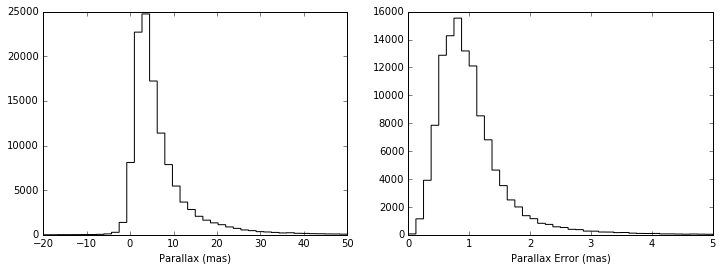

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].hist(hip['Plx'], histtype='step', color='k', bins=40, range=(-20, 50))
ax[1].hist(hip['e_Plx'], histtype='step', color='k', bins=40, range=(0, 5))

ax[0].set_xlabel('Parallax (mas)')
ax[1].set_xlabel('Parallax Error (mas)')

plt.show()

In [39]:
from scipy.integrate import quad
from scipy.optimize import minimize

upper = 10000.0

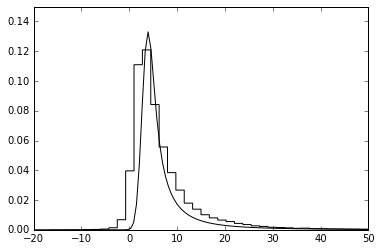

In [101]:
def get_integrand(x, y, gamma, sigma):
    return np.power(x, -(gamma+1.0)) * np.exp(-0.5*((y-x)/sigma)**2)


sigma = 1.5
gamma, L, U = 1.5,  3.0, 100.0 # 0.12

x = np.linspace(-10.0, 50.0, 100)
integral = np.zeros(len(x))
coeff = 1.0/np.sqrt(2.0*np.pi)/sigma * gamma / (L**(-gamma) - U**(-gamma))
for i in np.arange(len(x)):
    args = x[i], gamma, 1.0
    sol = quad(get_integrand, L, U, args=args)
    integral[i] = sol[0]
    
    # print i, x[i], integral[i]
    
plt.plot(x, coeff*integral, color='k')



plt.hist(hip['Plx'], histtype='step', color='k', bins=40, range=(-20, 50), normed=True)

plt.ylim(0.0, 0.15)
plt.show()

In [62]:
def ln_posterior_minimize(x, data, sigma):
    N = len(data)
    
    gamma, L = x

    if L<0.0 or L > 5.0:
        return np.inf
    if gamma<0.01 or gamma>10.0:
        return np.inf

    ll = ln_likelihood(x, data, sigma)

    return -ll

In [63]:
def ln_likelihood(x, data, sigma):

    gamma, L = x

    N = len(data)


    integral = np.zeros(N)

    ran_indices = np.arange(N)
#    ran_indices = np.random.randint(len(data), size=N)


    for j in np.arange(N):
        i = ran_indices[j]
        args = data[i], gamma, sigma[i]
        
        # If integration range is negative
        if max(L, data[i]-3.0*sigma[i]) > min(upper, data[i]+3.0*sigma[i]): 
            print "Inf:", i, L, data[i]-3.0*sigma[i], upper, data[i]+3.0*sigma[i]
            return -np.inf

        sol = quad(get_integrand, max(L, data[i]-3.0*sigma[i]), min(upper, data[i]+3.0*sigma[i]), \
                   args=args, epsrel=1.0e-1, epsabs=1.0e-1)
        integral[j] = sol[0]
        
        # For very small (or negative) integrals, set to a small, near-zero value
        if integral[j] <=0.0 or np.isnan(integral[j]): integral[j]=1.0e-100

        
            
    ln_likelihood = - N/2.0 * np.log(2.0*np.pi) \
                        + N * np.log(gamma) \
                        - N * np.log(np.power(L, -gamma) - np.power(upper, -gamma)) \
                        + np.sum(np.log(integral))

    print gamma, L, ln_likelihood
                    
    return ln_likelihood


In [57]:
# start = time.time()
# x = 1.0, 0.10
# print ln_posterior_minimize(x, hip['Plx'][hip['Plx']>-2.0], hip['e_Plx'][hip['Plx']>-2.0])
# print "Elapsed time:", time.time()-start


In [64]:
def run_optimize(plx, sigma, ndim=3):

    # Initial Position
    p0 = np.array([1.0, 0.1])

    args = plx, sigma
    res = minimize(ln_posterior_minimize, p0, args=args, method='Nelder-Mead')

    return res

In [65]:
run_optimize(hip['Plx'][hip['Plx']>-2.0], hip['e_Plx'][hip['Plx']>-2.0])

1.0 0.1 -590972.288263
1.05 0.1 -604478.14719
1.0 0.105 -586538.128962
0.95 0.105 -573443.517007
0.9 0.1075 -558647.562199
Inf: 59202 0.1125 -3.85 10000.0 0.11
0.975 0.103125 -581562.600017
0.875 0.105625 -553770.669197
0.8125 0.1059375 -538073.454624
Inf: 59202 0.1103125 -3.85 10000.0 0.11
0.915625 0.104921875 -564634.715734
0.796875 0.108515625 -532538.606342
Inf: 59202 0.1103125 -3.85 10000.0 0.11
0.709375 0.106953125 -513182.15993
0.6140625 0.1066796875 -492778.073929
0.5984375 0.1092578125 -488316.175202
Inf: 59202 0.11091796875 -3.85 10000.0 0.11
0.415625 0.107421875 -458381.080938
0.225 0.106875 -445041.943137
0.209375 0.109453125 -444757.684786
0.4078125 0.1087109375 -456945.20428


KeyboardInterrupt: 

### Now, let's select all rNLTT stars with Hipparchos numbers

In [14]:
t_hip_tmp = t_full[np.where(t_full['HIP']!=0)[0]]

# Only non-repeating entries
vals, indices = np.unique(t_hip['NLTT'], return_index=True)
t_hip = t_hip_tmp[indices]


dtype = [('ID','i8'),('NLTT','i8'),('ra','f8'),('dec','f8'),('mu_ra','f8'),('mu_dec','f8'), \
         ('mu_ra_err','f8'),('mu_dec_err','f8'),('B','f8'),('V','f8'), \
         ('plx','f8'),('plx_err','f8')]

t = np.zeros(len(t_hip), dtype=dtype)
t['ID'] = t_hip['HIP']
t['NLTT'] = t_hip['NLTT']
t['ra'] = t_hip['ra']
t['dec'] = t_hip['dec']
t['mu_ra'] = t_hip['mu_ra']
t['mu_dec'] = t_hip['mu_dec']
t['mu_ra_err'] = t_hip['mu_ra_err']
t['mu_dec_err'] = t_hip['mu_dec_err']
t['B'] = t_hip['B']
t['V'] = t_hip['V']

# Get parallaxes, by first finding indices matching two catalogs
idx = np.zeros(len(t_hip), dtype='i8')
for i in np.arange(len(t_hip)):
    idx[i] =int(np.where(t_hip[i]['HIP'] == hip['HIP'])[0][0])
    
t['plx'] = hip['Plx'][idx]
t['plx_err'] = hip['e_Plx'][idx]

In [15]:
# Run search for wide binaries
p_out = P_posterior.match_binaries(t)

Generating binaries...
We are testing 8288 stars...
0 4.90805792809
13 16 139 172 428 473 [  9.22422820e-12] 7.84924080997e-09 [ 0.99765516]
13 17 139 173 428 473 [  8.42135507e-12] 7.97096200493e-09 [ 0.99789145]
15 8285 157 58834 436 169 [  1.21995570e-08] 1.8327720457e-105 [  7.51163362e-98]
16 17 172 173 473 473 [  4.85668404e-14] 2.10276743051e-08 [ 0.99999538]
19 20 194 195 493 495 [  2.03282469e-09] 1.04624665316e-09 [ 0.204669]
19 21 194 196 493 495 [  2.06391485e-09] 1.07173894167e-09 [ 0.20612074]
20 21 195 196 495 495 [  2.44532842e-11] 2.90588475028e-08 [ 0.99831981]
54 72 514 609 898 1022 [  2.28122850e-07] 1.40068284437e-270 [  3.07001873e-264]
65 74 582 627 996 1055 [  8.34871362e-09] 6.8834189605e-15 [  4.12244115e-07]
67 90 588 795 1000 1275 [  6.76496349e-08] 0.0 [ 0.]
74 94 627 803 1055 1295 [  1.28112440e-06] 0.0 [ 0.]
74 100 627 838 1055 1334 [  2.36223934e-07] 3.57683285466e-135 [  7.57085192e-129]
76 105 639 867 1078 1389 [  2.78984963e-08] 1.04317729195e-103 [  

KeyboardInterrupt: 

In [31]:
print t['']

519
